# 1. Get data

In [58]:
import matplotlib.pyplot as plt
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib 
from tqdm import tqdm
matplotlib.rcParams['figure.figsize'] = [15, 5]


In [59]:
def get_test_logs(path:str, prefix:str, get_only_latest:bool):
    """get all test result filenames
    Args:
        path (str): path to test_cases
        prefix (str): prefix of log file
        get_only_latest (bool): if true return only latest file else return all files
    Returns:
        list of dicts, each dict corresponds for testcase 0-49
    """
    result_files = []
    test_dirs = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path,folder))]
    
    for challange in (test_dirs):
        kolvo_robotov = re.match(r'^(\d+)', challange).group(1)
        robot_challange_path= os.path.join(path,challange)
        test_cases = [folder for folder in os.listdir(robot_challange_path) if os.path.isdir(os.path.join(robot_challange_path,folder)) and (re.fullmatch(r"test_number\d+",folder) is not None)]
        
        for test in tqdm(test_cases):
            test_number = int(re.search(r'\d+$', test).group())
            test_dir = os.path.join(robot_challange_path,test)
            planner_generated_dirs = [ d for d in os.listdir(test_dir) if (prefix in d) and os.path.isdir(os.path.join(test_dir,d))]
            # print(os.listdir(test_dir))
            # break
            for planned_dir in (planner_generated_dirs):
                full_planned_dir = os.path.join(test_dir,planned_dir)
                seed =  int(re.search(r'\d+$', planned_dir).group())
                if "robot_trajectories.json" not in os.listdir(full_planned_dir):
                    continue
                try:
                    with open(os.path.join(full_planned_dir,"robot_trajectories.json"),'r') as f:
                        data_traj = json.load(f)
                except json.JSONDecodeError as e:
                    print(e)
                    print(full_planned_dir)
                    continue
                result = False
                error = ""
                if isinstance(data_traj[-1],dict):
                    if "result" in data_traj[-1]:
                        result = data_traj[-1]["result"]
                    elif "error" in data_traj[-1]:
                        error = data_traj[-1]["error"]
                        if "result" in data_traj[-2]:
                            result = data_traj[-2]["result"]
                        else:
                            print(full_planned_dir)
                            print(data_traj[-1])
                    else:
                        print(full_planned_dir)
                        print(data_traj[-1])
                else:
                    print(full_planned_dir)
                    print(data_traj[-1])
                logs = [ d for d in os.listdir(full_planned_dir) if ("planner_logs" in d)]
                one_test_result_files = []
                for log in logs:
                    
                    pattern = r'start_time_(\d+\.\d+).*?planner_logs_(\d+).*?robot_number_(\d+).json$'
                    match = re.search(pattern, log)
                    if not match:
                        print(full_planned_dir,log)
                        continue
                    assert(match)
                    start_time = match.group(1)
                    timestamp = match.group(2)
                    robot_number = match.group(3)
                    log_path = os.path.join(full_planned_dir,log)
                    with open(log_path,'r') as f:
                        data = json.load(f)
                    if not data["final_planner_data"]["has_result"]:
                        continue
                    data["final_planner_data"].pop("final_path")
                    
                    one_test_result_files.append({
                    "start_time":float(start_time),
                    "timestamp": int(timestamp),
                    "robot_number":int(robot_number),
                    "data":data,
                    "file_path":log_path
                })
                    
                result_files.append({
                    "test_case_id":int(test_number),
                    "kolvo_robotob":kolvo_robotov,
                    "success":result,
                    "dir_path":planned_dir,
                    "seed":seed,
                    "error":error,
                    "planning_instances":one_test_result_files
                    # "robot_trajectories":data_traj,
                })
    return result_files


In [60]:
test_dir = "../multiagent_tests"
msirrt_test_files = get_test_logs(path = test_dir,prefix = "msirrt", get_only_latest = False)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 100.62it/s]


In [61]:
# with open("MSIRRT_multiagent_results.json",'w') as f:
#     json.dump(msirrt_test_files,f)

In [62]:
# with open("MSIRRT_multiagent_results.json",'r') as f:
#     msirrt_test_files = json.load(f)

In [63]:
test_dir = "../multiagent_tests"
strrt_test_files = get_test_logs(path = test_dir,prefix = "strrt", get_only_latest = False)


100%|██████████| 3/3 [00:00<00:00, 49.19it/s]


In [64]:
# with open("STRRT_multiagent_results.json",'w') as f:
#     json.dump(strrt_test_files,f)

In [65]:
# with open("STRRT_multiagent_results.json",'r') as f:
#     strrt_test_files = json.load(f)

# Execution Time

In [10]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [66]:
sirrt_res = msirrt_test_files
strrt_res = strrt_test_files

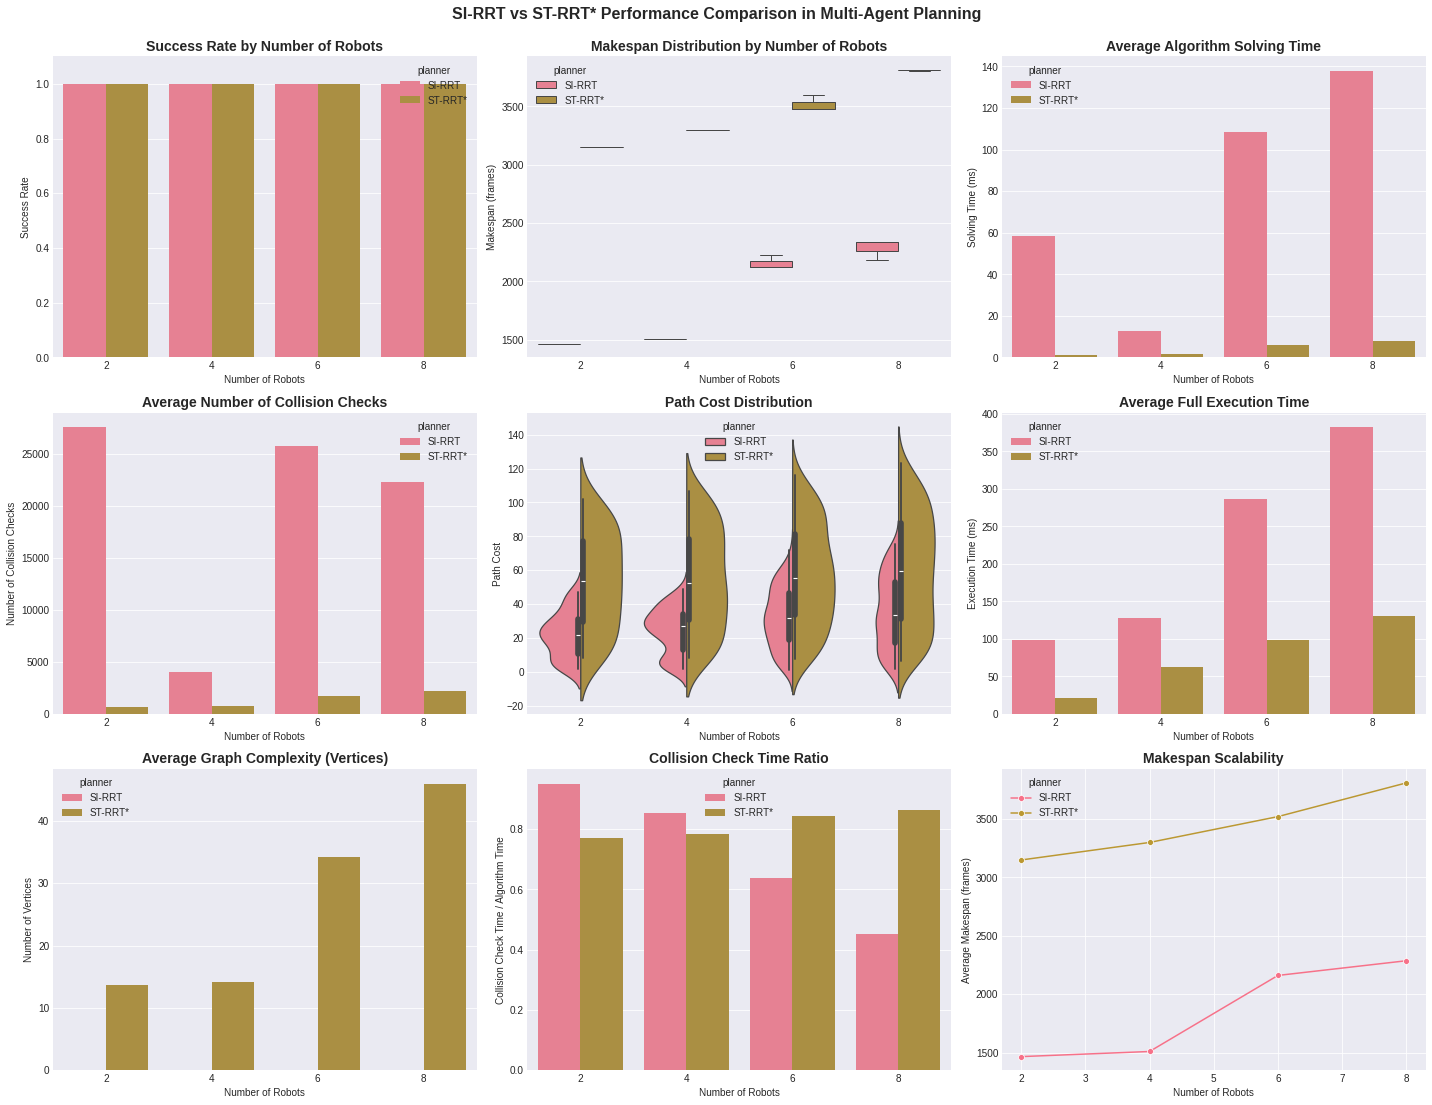

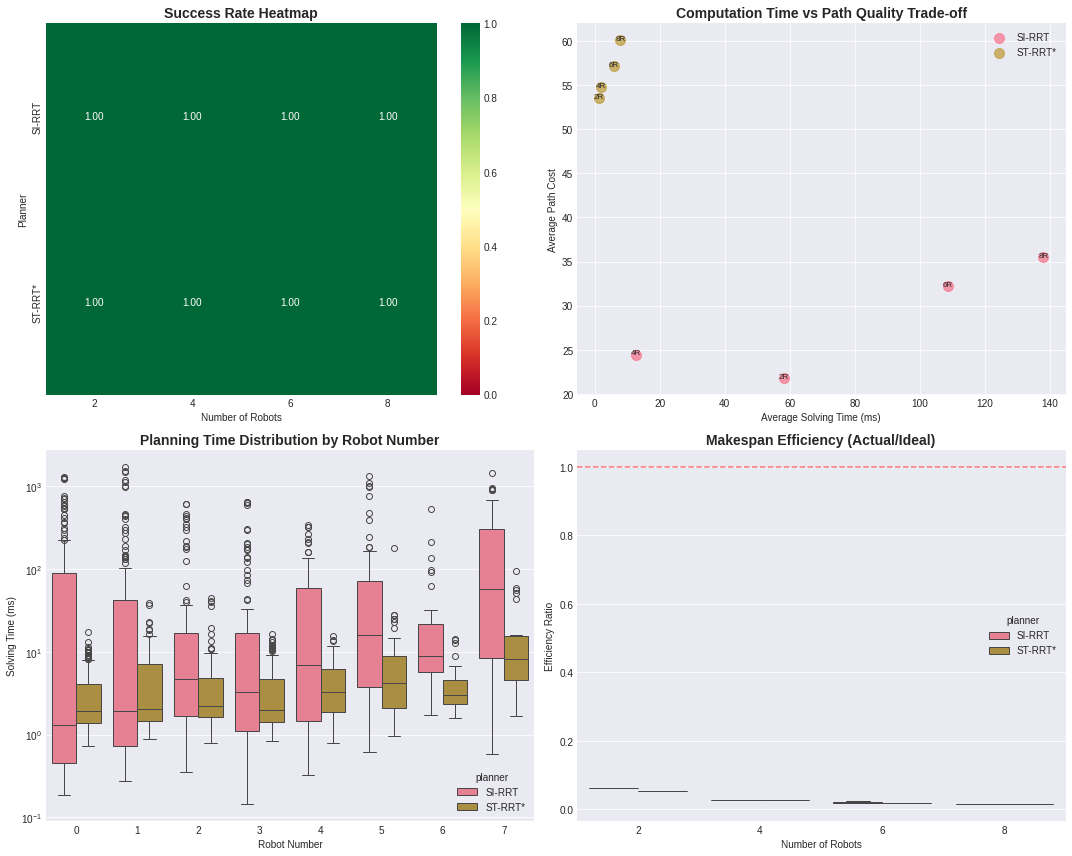

=== Summary Statistics ===

Success Rates by Planner and Number of Robots:
planner     SI-RRT  ST-RRT*
num_robots                 
2              1.0      1.0
4              1.0      1.0
6              1.0      1.0
8              1.0      1.0


Average Makespan by Planner and Number of Robots:
                       mean    std
planner num_robots                
SI-RRT  2           1466.40   0.00
        4           1510.20   0.00
        6           2160.95  57.31
        8           2286.72  85.64
ST-RRT* 2           3148.79   0.00
        4           3298.72   0.00
        6           3519.96  67.23
        8           3808.47   3.21


Average Solving Time (ms) by Planner and Number of Robots:
planner  num_robots
SI-RRT   2              58.28
         4              12.82
         6             108.52
         8             137.96
ST-RRT*  2               1.36
         4               1.91
         6               5.86
         8               7.97
Name: algorithm_solving_time_ns, d

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract data from the results
def extract_data(results):
    data = []
    
    for planner_name, planner_results in [('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)]:
        for test_result in planner_results:
            test_id = test_result['test_case_id']
            num_robots = int(test_result['kolvo_robotob'])
            success = test_result['success']
            seed = test_result['seed']
            
            # Extract planning instances data
            for instance in test_result['planning_instances']:
                robot_num = instance['robot_number']
                start_time = instance['start_time']
                
                # Extract metrics from data
                instance_data = instance['data']
                
                data.append({
                    'planner': planner_name,
                    'test_id': test_id,
                    'num_robots': num_robots,
                    'success': success,
                    'seed': seed,
                    'robot_number': robot_num,
                    'start_time': start_time,
                    'has_result': instance_data['final_planner_data']['has_result'],
                    'path_cost': instance_data['final_planner_data'].get('path_cost', np.nan),
                    'algorithm_solving_time_ns': instance_data['algorithm_solving_time_ns'],
                    'collision_check_time_ns': instance_data['collision_check_time_ns'],
                    'number_of_collision_checks': instance_data['number_of_collision_checks'],
                    'full_execution_time_ns': instance_data['full_execution_time_ns'],
                    'number_of_vertices': instance_data['final_planner_data'].get('number_of_vertices', 0),
                    'number_of_edges': instance_data['final_planner_data'].get('number_of_edges', 0)
                })
    
    return pd.DataFrame(data)

# Create dataframe
df = extract_data([('SI-RRT', sirrt_res), ('ST-RRT*', strrt_res)])

# Calculate overall makespan for each test (last robot arrival time)
def calculate_makespan(group):
    if not group['has_result'].all():
        return np.nan
    # Makespan is the maximum end time (start_time + path_cost*50) across all robots
    end_times = group['start_time'] + group['path_cost'] * 30 
    return end_times.max()

# Group by test configuration and calculate metrics
makespan_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed']).apply(calculate_makespan).reset_index()
makespan_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'makespan']

# Calculate success rate
success_df = df.groupby(['planner', 'test_id', 'num_robots', 'seed'])['has_result'].all().reset_index()
success_df.columns = ['planner', 'test_id', 'num_robots', 'seed', 'all_robots_success']

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Success Rate by Number of Robots
ax1 = plt.subplot(3, 3, 1)
success_rate = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().reset_index()
sns.barplot(data=success_rate, x='num_robots', y='all_robots_success', hue='planner', ax=ax1)
ax1.set_title('Success Rate by Number of Robots', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.1)

# 2. Makespan Distribution (Boxplot)
ax2 = plt.subplot(3, 3, 2)
makespan_valid = makespan_df.dropna()
sns.boxplot(data=makespan_valid, x='num_robots', y='makespan', hue='planner', ax=ax2)
ax2.set_title('Makespan Distribution by Number of Robots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('Makespan (frames)')

# 3. Algorithm Solving Time
ax3 = plt.subplot(3, 3, 3)
avg_solving_time = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean().reset_index()
avg_solving_time['solving_time_ms'] = avg_solving_time['algorithm_solving_time_ns'] / 1e6
sns.barplot(data=avg_solving_time, x='num_robots', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Average Algorithm Solving Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Robots')
ax3.set_ylabel('Solving Time (ms)')

# 4. Number of Collision Checks
ax4 = plt.subplot(3, 3, 4)
avg_collision_checks = df.groupby(['planner', 'num_robots'])['number_of_collision_checks'].mean().reset_index()
sns.barplot(data=avg_collision_checks, x='num_robots', y='number_of_collision_checks', hue='planner', ax=ax4)
ax4.set_title('Average Number of Collision Checks', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Number of Collision Checks')

# 5. Path Cost Distribution
ax5 = plt.subplot(3, 3, 5)
path_cost_valid = df[df['has_result'] == True]
sns.violinplot(data=path_cost_valid, x='num_robots', y='path_cost', hue='planner', ax=ax5, split=True)
ax5.set_title('Path Cost Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Number of Robots')
ax5.set_ylabel('Path Cost')

# 6. Full Execution Time
ax6 = plt.subplot(3, 3, 6)
avg_exec_time = df.groupby(['planner', 'num_robots'])['full_execution_time_ns'].mean().reset_index()
avg_exec_time['exec_time_ms'] = avg_exec_time['full_execution_time_ns'] / 1e6
sns.barplot(data=avg_exec_time, x='num_robots', y='exec_time_ms', hue='planner', ax=ax6)
ax6.set_title('Average Full Execution Time', fontsize=14, fontweight='bold')
ax6.set_xlabel('Number of Robots')
ax6.set_ylabel('Execution Time (ms)')

# 7. Graph Complexity (Number of Vertices)
ax7 = plt.subplot(3, 3, 7)
avg_vertices = df[df['has_result'] == True].groupby(['planner', 'num_robots'])['number_of_vertices'].mean().reset_index()
sns.barplot(data=avg_vertices, x='num_robots', y='number_of_vertices', hue='planner', ax=ax7)
ax7.set_title('Average Graph Complexity (Vertices)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Number of Robots')
ax7.set_ylabel('Number of Vertices')

# 8. Collision Check Time Ratio
ax8 = plt.subplot(3, 3, 8)
df['collision_check_ratio'] = df['collision_check_time_ns'] / df['algorithm_solving_time_ns']
avg_collision_ratio = df.groupby(['planner', 'num_robots'])['collision_check_ratio'].mean().reset_index()
sns.barplot(data=avg_collision_ratio, x='num_robots', y='collision_check_ratio', hue='planner', ax=ax8)
ax8.set_title('Collision Check Time Ratio', fontsize=14, fontweight='bold')
ax8.set_xlabel('Number of Robots')
ax8.set_ylabel('Collision Check Time / Algorithm Time')

# 9. Scalability Analysis - Makespan Growth
ax9 = plt.subplot(3, 3, 9)
makespan_growth = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].mean().reset_index()
sns.lineplot(data=makespan_growth, x='num_robots', y='makespan', hue='planner', marker='o', ax=ax9)
ax9.set_title('Makespan Scalability', fontsize=14, fontweight='bold')
ax9.set_xlabel('Number of Robots')
ax9.set_ylabel('Average Makespan (frames)')

plt.tight_layout()
plt.suptitle('SI-RRT vs ST-RRT* Performance Comparison in Multi-Agent Planning', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional detailed analysis plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Success Rate Heatmap
ax1 = axes[0, 0]
success_pivot = success_df.groupby(['planner', 'num_robots'])['all_robots_success'].mean().unstack()
sns.heatmap(success_pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=1)
ax1.set_title('Success Rate Heatmap', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Robots')
ax1.set_ylabel('Planner')

# 2. Computation Time vs Path Quality Trade-off
ax2 = axes[0, 1]
tradeoff_df = df[df['has_result'] == True].groupby(['planner', 'num_robots']).agg({
    'algorithm_solving_time_ns': 'mean',
    'path_cost': 'mean'
}).reset_index()
tradeoff_df['solving_time_ms'] = tradeoff_df['algorithm_solving_time_ns'] / 1e6

for planner in tradeoff_df['planner'].unique():
    planner_data = tradeoff_df[tradeoff_df['planner'] == planner]
    ax2.scatter(planner_data['solving_time_ms'], planner_data['path_cost'], 
                label=planner, s=100, alpha=0.7)
    # Add robot count labels
    for _, row in planner_data.iterrows():
        ax2.annotate(f"{row['num_robots']}R", (row['solving_time_ms'], row['path_cost']), 
                    fontsize=8, ha='center')

ax2.set_xlabel('Average Solving Time (ms)')
ax2.set_ylabel('Average Path Cost')
ax2.set_title('Computation Time vs Path Quality Trade-off', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Per-Robot Planning Time Distribution
ax3 = axes[1, 0]
robot_time_df = df[df['has_result'] == True].copy()
robot_time_df['solving_time_ms'] = robot_time_df['algorithm_solving_time_ns'] / 1e6
sns.boxplot(data=robot_time_df, x='robot_number', y='solving_time_ms', hue='planner', ax=ax3)
ax3.set_title('Planning Time Distribution by Robot Number', fontsize=14, fontweight='bold')
ax3.set_xlabel('Robot Number')
ax3.set_ylabel('Solving Time (ms)')
ax3.set_yscale('log')

# 4. Makespan Efficiency (Makespan / Ideal Makespan)
ax4 = axes[1, 1]
# Calculate ideal makespan (assuming no conflicts, just sum of individual path costs)
ideal_makespan = df[df['has_result'] == True].groupby(['planner', 'test_id', 'num_robots', 'seed']).agg({
    'path_cost': 'sum'
}).reset_index()
ideal_makespan.columns = ['planner', 'test_id', 'num_robots', 'seed', 'ideal_makespan']
ideal_makespan['ideal_makespan'] = ideal_makespan['ideal_makespan'] * 50  # Convert to frames

efficiency_df = makespan_valid.merge(ideal_makespan, on=['planner', 'test_id', 'num_robots', 'seed'])
efficiency_df['efficiency'] = efficiency_df['makespan'] / efficiency_df['ideal_makespan']

sns.boxplot(data=efficiency_df, x='num_robots', y='efficiency', hue='planner', ax=ax4)
ax4.set_title('Makespan Efficiency (Actual/Ideal)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Robots')
ax4.set_ylabel('Efficiency Ratio')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Ideal')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Summary Statistics ===\n")
print("Success Rates by Planner and Number of Robots:")
print(success_rate.pivot(index='num_robots', columns='planner', values='all_robots_success'))
print("\n")

print("Average Makespan by Planner and Number of Robots:")
makespan_summary = makespan_valid.groupby(['planner', 'num_robots'])['makespan'].agg(['mean', 'std']).round(2)
print(makespan_summary)
print("\n")

print("Average Solving Time (ms) by Planner and Number of Robots:")
time_summary = df.groupby(['planner', 'num_robots'])['algorithm_solving_time_ns'].mean() / 1e6
print(time_summary.round(2))

In [5]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load all your results into a list of dicts:
# results = ...   # (your parsed results from JSON files)

# 2. Flatten the data for SI-RRT and ST-RRT* into a DataFrame
records = []
for test in all_tests:  # You need to combine all test results into all_tests
    for pi in test['planning_instances']:
        data = pi['data']
        robot_number = pi['robot_number']
        # Extracting goal_number from 'path_to_scene_json' is also possible
        final = data['final_planner_data']
        rec = {
            'test_case_id': test['test_case_id'],
            'seed': test['seed'],
            'kolvo_robotob': int(test['kolvo_robotob']),
            'planner': data['planner_type'],
            'robot_number': robot_number,
            'success': final.get('has_result', False),
            'path_cost': final.get('path_cost', None),
            'full_execution_time_ns': data.get('full_execution_time_ns', None),
            'num_collision_checks': data.get('number_of_collision_checks', None),
            # add other metrics as needed
        }
        records.append(rec)

df = pd.DataFrame(records)

# 3. Compute overall makespan for each test (last arrival time among all robots)
df['test_key'] = df['test_case_id'].astype(str) + '_' + df['seed'].astype(str) + '_' + df['planner'] + '_' + df['kolvo_robotob'].astype(str)
makespans = df.groupby('test_key')['path_cost'].max().reset_index()
makespans = makespans.merge(df[['test_key', 'kolvo_robotob', 'planner']].drop_duplicates(), on='test_key')

# 4. Success Rate by Robot Count and Planner
success_rate = df.groupby(['kolvo_robotob', 'planner'])['success'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='kolvo_robotob', y='success', hue='planner', data=success_rate)
plt.title('Success Rate by Robot Count and Planner')
plt.ylabel('Success Rate')
plt.xlabel('Number of Robots')
plt.tight_layout()
plt.show()

# 5. Makespan Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='kolvo_robotob', y='path_cost', hue='planner', data=makespans)
plt.title('Distribution of Makespan by Robot Count and Planner')
plt.ylabel('Makespan (last arrival among robots)')
plt.xlabel('Number of Robots')
plt.tight_layout()
plt.show()

# 6. Per-Instance Path Cost Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='kolvo_robotob', y='path_cost', hue='planner', data=df)
plt.title('Distribution of Individual Path Costs')
plt.ylabel('Path Cost')
plt.xlabel('Number of Robots')
plt.tight_layout()
plt.show()

# 7. Collision Checks
plt.figure(figsize=(10, 6))
sns.boxplot(x='kolvo_robotob', y='num_collision_checks', hue='planner', data=df)
plt.title('Number of Collision Checks per Instance')
plt.ylabel('Collision Checks')
plt.xlabel('Number of Robots')
plt.tight_layout()
plt.show()

# 8. Execution Time (convert to ms)
df['full_execution_time_ms'] = df['full_execution_time_ns'] / 1e6
plt.figure(figsize=(10, 6))
sns.boxplot(x='kolvo_robotob', y='full_execution_time_ms', hue='planner', data=df)
plt.title('Full Execution Time per Planning Instance (ms)')
plt.ylabel('Execution Time (ms)')
plt.xlabel('Number of Robots')
plt.tight_layout()
plt.show()


NameError: name 'all_tests' is not defined

In [22]:
execution_time_stats1={}
execution_time_stats1["test"]=[]
execution_time_stats1["algorithm_solving_time"]=[]
execution_time_stats1["planner_type"]=[]
execution_time_stats1["has_result"]=[]
execution_time_stats1["arrival_time"]=[]

for challenge in stats:
        
    
    for test in stats[challenge]: 
        if 'strrt' in stats[challenge][test] and 'msirrt' in stats[challenge][test] and 'drgbt' in stats[challenge][test]:
                tstrrt, tmsirrt = [], []
                try:
                     for i in range(10):
                       if stats[challenge][test]['strrt'][i]['final_planner_data']['has_result']:
                            tstrrt.append(stats[challenge][test]['strrt'][i]['final_planner_data']['final_path'][-1]['time'])
                       if stats[challenge][test]['msirrt'][i]['final_planner_data']['has_result']:
                            tmsirrt.append(stats[challenge][test]['msirrt'][i]['final_planner_data']['final_path'][-1]['time'])
                except:
                     pass

                execution_time_stats1["test"].append(int(challenge[:challenge.find('_')]))
                execution_time_stats1["planner_type"].append('strrt')
                
                execution_time_stats1["has_result"].append(stats[challenge][test]['strrt'][0]['final_planner_data']['has_result'])
                execution_time_stats1["algorithm_solving_time"].append(np.mean(tstrrt))
                
                
                execution_time_stats1["test"].append(int(challenge[:challenge.find('_')]))
                execution_time_stats1["planner_type"].append('msirrt')
                execution_time_stats1["has_result"].append(stats[challenge][test]['msirrt'][0]['final_planner_data']['has_result'])
                execution_time_stats1["algorithm_solving_time"].append(np.mean(tmsirrt))
                

                execution_time_stats1["test"].append(int(challenge[:challenge.find('_')]))
                execution_time_stats1["planner_type"].append('drgbt')
                execution_time_stats1["has_result"].append(stats[challenge][test]['drgbt'][0]['final_planner_data']['has_result'])
                execution_time_stats1["algorithm_solving_time"].append(0)
                       
                
                
execution_time_stats = pd.DataFrame(execution_time_stats1)


In [23]:

import pandas as pd
import numpy as np

execution_time_stats1={}
execution_time_stats1["test"]=[]
execution_time_stats1["algorithm_solving_time"]=[]
execution_time_stats1["arrival_time"]=[]
execution_time_stats1["planner_type"]=[]
execution_time_stats1["has_result"]=[]

for challenge in stats:
        
    
    for test in stats[challenge]: 
        for planner_type in ['strrt','msirrt','drgbt']:
            if planner_type in stats[challenge][test]:
                execution_time_stats1["test"].append(int(challenge[:challenge.find('_')]))
                execution_time_stats1["algorithm_solving_time"].append(np.mean(np.array([x['algorithm_solving_time_ns']/10**9 for x in stats[challenge][test][planner_type]])))
                execution_time_stats1["planner_type"].append(planner_type)
                execution_time_stats1["has_result"].append(np.mean(np.array([x['final_planner_data']['has_result'] for x in stats[challenge][test][planner_type]])))
                if execution_time_stats1["has_result"][-1]:
                    execution_time_stats1["arrival_time"].append(np.mean(np.array([x['final_planner_data']['final_path'][-1]["time"] for x in stats[challenge][test][planner_type] if x['final_planner_data']['has_result']])))
                else:
                    execution_time_stats1["arrival_time"].append(-1)

            elif planner_type == 'drgbt':
                execution_time_stats1["test"].append(int(challenge[:challenge.find('_')]))
                execution_time_stats1["algorithm_solving_time"].append(0)
                execution_time_stats1["planner_type"].append(planner_type)
                execution_time_stats1["has_result"].append(False)
                execution_time_stats1["arrival_time"].append(-1)
            else:
                assert(False)

execution_time_stats = pd.DataFrame(execution_time_stats1)

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(execution_time_stats.groupby(["test","planner_type"]).mean())

                   algorithm_solving_time  arrival_time has_result
test planner_type                                                 
1    drgbt                       0.000000     -1.000000        0.0
     msirrt                      0.000627     19.046440        1.0
     strrt                       0.002740     10.630489        1.0


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


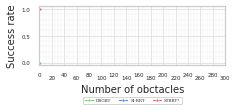

In [25]:
import seaborn as sns
import matplotlib as mpl

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=0.5, rc={"lines.linewidth": 1, "lines.markersize": 3})
sns.set_palette("muted")
fig, ax = plt.subplots(figsize=(3.4, 2))  # ширина 3.4 дюйма, высота 2.5 дюйма

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],  # Specific font, commonly used in scientific journals
    "font.size": 10,                # General font size
    "axes.titlesize": 12,           # Font size for title
    "axes.labelsize": 1000,           # Font size for axis labels
    "legend.fontsize": 4,           # Font size for legend
    "xtick.labelsize": 9,           # Font size for x-tick labels
    "ytick.labelsize": 9,           # Font size for y-tick labels
})


success_rate = execution_time_stats.groupby(["test","planner_type"]).mean()
pl = sns.lineplot(x="test", y="has_result",
             hue="planner_type",
             data=success_rate,marker="o", dashes=False, ax = ax, 
             palette=[sns.color_palette("muted")[2],sns.color_palette("muted")[0],sns.color_palette("muted")[3]],
             legend=True)
# pl.get_legend().remove()

new_title = ''
pl.legend_.set_title(new_title)
# replace labels
new_labels = ['DRGBT','SI-RRT','STRRT*']
for t, l in zip(pl.legend_.texts, new_labels):
    t.set_text(l)
    

sns.move_legend(ax, ncol=4, bbox_to_anchor=(0.5, -0.5), loc="upper center")

pl.set_xticks(range(0,301,20))

ax.minorticks_on()
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
ax.grid(which='minor', color='#EEEEEE', linewidth=0.4)

pl.set_ylabel("Success rate",fontsize=10)
pl.set_xlabel("Number of obctacles",fontsize=10)
# Stagger the x-axis labels
for i, label in enumerate(ax.get_xticklabels()):
    label.set_y(0.05 if i % 2 == 0 else 0)  # Alternates y position for staggered effect


plt.tight_layout()

plt.savefig("success_rate.pdf", format="pdf", bbox_inches="tight")

# pl.set_ylim(0,1.1)
plt.show()

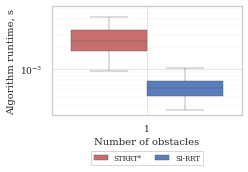

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=0.5, rc={"lines.linewidth": 0.005, "lines.markersize": 0})
sns.set_palette("muted")

# Configure font for scientific style
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],   # Use DejaVu Serif if Times New Roman is unavailable
    "font.size": 10,                  # General font size
    "axes.titlesize": 12,             # Font size for title
    "axes.labelsize": 10,             # Font size for axis labels
    "legend.fontsize": 7,             # Font size for legend
    "xtick.labelsize": 9,             # Font size for x-tick labels
    "ytick.labelsize": 9              # Font size for y-tick labels
})

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(3.4, 2))  # Width: 3.4 inches, Height: 2 inches



# Boxplot with log-scaled y-axis
pl = sns.boxplot(
    x="test", y="algorithm_solving_time",
    hue="planner_type", data=execution_time_stats.loc[
        (execution_time_stats['test'] <= 120) &
        (execution_time_stats['planner_type'].isin(['strrt', 'msirrt']))
    ],
    ax=ax,
    palette=[sns.color_palette("muted")[3],sns.color_palette("muted")[0]],
    linewidth=0.4
)

# Adjust the plot labels
new_title = ''
pl.legend_.set_title(new_title)
# replace labels
new_labels = ['STRRT*','SI-RRT']
for t, l in zip(pl.legend_.texts, new_labels):
    t.set_text(l)
    

sns.move_legend(ax, ncol=4, bbox_to_anchor=(0.5, -0.3), loc="upper center")

pl.set_yscale('log')

pl.set_xlabel("Number of obstacles")
pl.set_ylabel("Algorithm runtime, s")

# Enable minor ticks
pl.minorticks_on()

# Customize the grid
pl.grid(which='major', color='#DDDDDD', linewidth=0.8)
pl.grid(which='minor', color='#EEEEEE', linewidth=0.4)
# raw_adc_ax.yaxis.set_minor_formatter(FormatStrFormatter("%3d"))
# Stagger the x-axis labels for readability
# for i, label in enumerate(ax.get_xticklabels()):
#     label.set_y(0.05 if i % 2 == 0 else 0)

# Save and display the plot
# plt.tight_layout()
plt.savefig("algo_time.pdf", format="pdf", bbox_inches="tight")
plt.show()


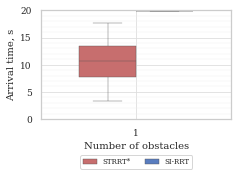

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=0.5, rc={"lines.linewidth": 0.03, "lines.markersize": 0})
sns.set_palette("muted")

# Configure font for scientific style
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],   # Use DejaVu Serif if Times New Roman is unavailable
    "font.size": 10,                  # General font size
    "axes.titlesize": 12,             # Font size for title
    "axes.labelsize": 10,             # Font size for axis labels
    "legend.fontsize": 7,             # Font size for legend
    "xtick.labelsize": 9,             # Font size for x-tick labels
    "ytick.labelsize": 9              # Font size for y-tick labels
})

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(3.4, 2))  # Width: 3.4 inches, Height: 2 inches



# Boxplot with log-scaled y-axis
pl = sns.boxplot(
    x="test", y="arrival_time",
    hue="planner_type", data=execution_time_stats.loc[
        (execution_time_stats['test'] <= 120) &
        (execution_time_stats['planner_type'].isin(['strrt', 'msirrt']))
    ],
    ax=ax,
    palette=[sns.color_palette("muted")[3],sns.color_palette("muted")[0]],
    linewidth=0.4,
    width=0.6
)

new_title = ''
pl.legend_.set_title(new_title)
# replace labels
new_labels = ['STRRT*','SI-RRT']
for t, l in zip(pl.legend_.texts, new_labels):
    t.set_text(l)
    

sns.move_legend(ax, ncol=4, bbox_to_anchor=(0.5, -0.3), loc="upper center")

# pl.set_yscale('log')

pl.set_ylim(0,20)
pl.set_xlabel("Number of obstacles")# pl.set_yscale('log')
pl.set_ylabel("Arrival time, s")

# Enable minor ticks
pl.minorticks_on()

# Customize the grid
pl.grid(which='major', color='#DDDDDD', linewidth=0.8)
pl.grid(which='minor', color='#EEEEEE', linewidth=0.4)
# raw_adc_ax.yaxis.set_minor_formatter(FormatStrFormatter("%3d"))
# Stagger the x-axis labels for readability
# for i, label in enumerate(ax.get_xticklabels()):
#     label.set_y(0.05 if i % 2 == 0 else 0)

# Save and display the plot
# plt.tight_layout()
plt.savefig("arrive_time.pdf", format="pdf", bbox_inches="tight")
plt.show()
